In [15]:
import pandas
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

# Primer
### Maximum Likelihood Estimation

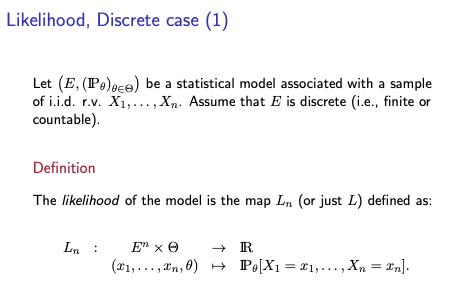

Probability gives the probability of a certain result given a distribution and a set of parameters. Likelihood gives the likelihood of a certain parameter given a distribution and a set of results. Likelihood can be seen as "reverse probability".

"Probability attaches to possible results; likelihood attaches to hypotheses."
-C. Randy Gallistel

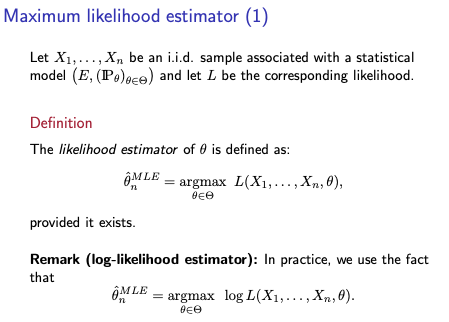

### Relative Copy Number

As we discussed in the previous slides, ABSOLUTE exists primarily to infer absolute copy numbers from relative values. We need to start with defining the equation for Relative Copy Number, *R(x)* for each *x* locus in the genome. Let *q(x)* be the integer (absolute CN), $\tau$ be the ploidy of the cancer cells (mean of *q(x)*), and $\alpha$ be the purity.

$$ AbsoluteCN(x) = \alpha * q(x) + 2(1 - \alpha) $$
$$ AveragePloidy = D = \alpha * \tau + 2(1 - \alpha) $$

By intuition, the relative total CN at a locus will be the Absolute CN divided by the average ploidy (of the mixed sample):

$$ R(x) = \frac{\alpha * q(x) + 2(1 - \alpha)}{D} $$

When considering allelic copy ratios (centered on *q(x)*=1, not *q(x)*=2), the equation becomes $ R(x) = \frac{2\alpha * q(x) + 2(1 - \alpha)}{D} $

#### Observations

At *x* with clonal deletion, *q(x)*=0 and $ R(x) = \frac{2(1-\alpha)}{D} $

The space between copy number levels equals $ \frac{\alpha}{D} $; obviously subclonal segments will appear between these discrete levels

If $ \alpha=1 $, $ R(x) = \frac{q(x)}{D} = \frac{q(x)}{\tau} $

# Determine Candidate Purity/Ploidy
### Model Setup

Inputs to the model are *N* allelic copy number segments $ x_i, i \in \{1,...,N\} $, each with error $ \sigma_i $ and corresponding genomic fraction $ w_i $. Each $ x_i $ is derived from one of the *Q* integer copy states or *Z*, a catch-all subclonal copy state, with $ S = Q \cup Z $ and $ P(s_i) $ is the probability $ x_i $ was generated from a copy state $ s_i $.

$$
\begin{array}{l}
s_{i} \sim \operatorname{Multinom}\left(p\left(s_{i} \mid w_{i}, \theta\right)\right) \\
x_{i}=\left\{\begin{array}{ll}
\mu_{q}+\epsilon_{i} & \text { if } s_{i} \in Q \\
u & \text { if } s_{i}=Z
\end{array}\right. \\
\epsilon_{i} \sim \mathcal{N}\left(0, \sigma_{i}^{2}+\sigma_{H}^{2}\right) \\
u \sim \mathcal{U}(d)
\end{array}
$$

Where $ \sigma_H $ is the sample noise in excess of $ \sigma_i $, the mixture weights $ \theta = \{\theta_s \in S\} $ specify the expected genomic fraction allocated to each copy-state, and *d* is the domain for the uniform density (default of 7).

### Multinomial Random Variable

A generalization of the binomial: a discrete random variable with *k* possible results with probability $ p_k $ of occurring and $ \sum p_k = 1 $, with *n* independent trials. It is supported on $ x_i \in \{0, ..., n\} $ with $ i \in \{1,...,k\} $ and $ \sum x_i = n $. The pmf is given by

$$ \begin{equation}
\frac{n !}{x_{1} ! \cdots x_{k} !} p_{1}^{x_{1}} \cdots p_{k}^{x_{k}}
\end{equation} $$

Mean and variance: $ E(X_i) = np_i $, $ Var(X_i) = np_i(1 - p_i) $

Note that the binomial can be recovered if $ k = 2 $.

Text(0.5, 0, 'Absolute Copy Number')

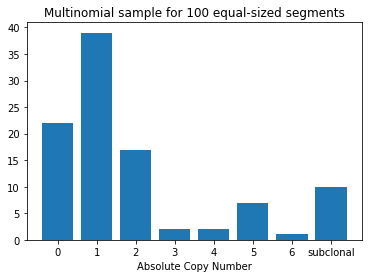

In [13]:
sample = ss.multinomial.rvs(n=100, p=[0.2, 0.45, 0.15, 0.03, 0.02, 0.02, 0.01, 0.12])
plt.bar(list(range(0,8)), sample, tick_label=['0', '1', '2', '3', '4', '5', '6', 'subclonal'])
plt.title('Multinomial sample for 100 equal-sized segments')
plt.xlabel('Absolute Copy Number')


In [ ]:
sample = ss.multinomial.rvs(n=100, p=[0.17, 0.15, 0.4, 0.07, 0.06, 0.02, 0.01, 0.12])
plt.bar(list(range(0,8)), sample, tick_label=['0', '1', '2', '3', '4', '5', '6', 'subclonal'])
plt.title('Multinomial sample for 100 equal-sized segments - WGD')
plt.xlabel('Absolute Copy Number')

### Likelihood Calculation

$$
\begin{equation}
\mathcal{L}\left(x_{i} \mid \mu, \sigma_{i}, \sigma_{H}, \theta, w_{i}\right)=\sum_{q \in Q}\left[P\left(q_{i} \mid w_{i}, \lambda\right) \mathcal{N}\left(x_{i} \mid \mu_{q}, \sigma_{i}^{2}+\sigma_{H}^{2}\right)\right]+P\left(z_{i} \mid w_{i}, \lambda\right) \mathcal{U}(d)
\end{equation}
$$

$ \lambda $ is calculated by Nelder Mead optimization of the $ L_2 $ loss of the $ \theta $ averaged over the whole genome (see ABSOLUTE paper for details).

The full log-likelihood is then given by $ \begin{equation}
\sum_{i=1}^{N} \log \mathcal{L}\left(x_{i} \mid \mu, \sigma_{i}, \sigma_{H}, \theta, w_{i}\right)
\end{equation} $


### Provisional Likelihood

Calculation of the log-likelihood requires knowledge of $ \theta $ and $ \sigma_H $, which we don't know a priori. Assuming the modes of the equation are invariant to fluctuations in these parameters, we can use an additional noise parameter ($ \sigma_p $ set to 0.01) in their stead to find the modes and then rank them using the original formula. The provisional likelihood for each $ x_i $ is then

$$ \begin{equation}
\mathcal{L}_{P}\left(x_{i} \mid \mu, \sigma_{i}, \sigma_{p}\right)=\sum_{q \in Q}\left[\mathcal{N}\left(x_{i} \mid \mu_{q}, \sigma_{i}^{2}+\sigma^{2}\right)\right]+\mathcal{U}(d)
\end{equation} $$

Candidate purity/ploidy pairs are identified by the optimization of the log-likelihood

$$ \begin{equation}
\sum_{i=1}^{N} \log \mathcal{L}_{p}\left(x_{i} \mid \mu, \sigma_{i}, \sigma_{p}\right)
\end{equation} $$

which is optimized with respect to $ b = 2(1 - \alpha) $ and $ \delta_\tau = \frac{\alpha}{D} $, initiated on a regular lattice spanning the domain of $ b $ and $ \delta_\tau $. (Is this solved just using Grid Search?)

# Calculate SCNA-fit Score

After finding the local maxima, $ \sigma_H $ and $ \theta $ must be found for each solution in order to calculate the SCNA-fit score. $ \sigma_H $ is optimized according to this formula

$$ \begin{equation}
\hat{\sigma}_{H}=\underset{\sigma_{H}}{\operatorname{argmax}} \sum_{i=1}^{N} \log \mathcal{L}\left(x_{i} \mid \hat{\mu}, \sigma_{i}, \sigma_{H}, \theta, w_{i}\right)
\end{equation} $$

and $ \theta $ is calculated for each $ \sigma_H $ by

$$ \begin{equation}
\hat{\theta}_{q}=\sum_{i=1}^{N} w_{i} \frac{\mathcal{N}\left(x_{i} \mid \hat{\mu}_{q}, \sigma_{i}^{2}+\sigma_{H}^{2}\right)}{\mathcal{L}_{P}\left(x_{i} \mid \hat{\mu}, \sigma_{i}, \sigma_{H}\right)} ; \hat{\theta}_{z}=\sum_{i=1}^{N} w_{i} \frac{\mathcal{U}(d)}{\mathcal{L}_{P}\left(x_{i} \mid \hat{\mu}, \sigma_{i}, \sigma_{H}\right)}
\end{equation} $$

The final SCNA-fit log-likelihood score for each mode can be calculated using these values above.

Estimates of the copy-state indicators for each segment are calculated with

$$\begin{equation}
\begin{array}{l}
\hat{\boldsymbol{q}}_{i}=P\left(q_{i} \mid w_{i}, \lambda\right) \frac{\mathcal{N}\left(x_{i} \mid \hat{\mu}_{q}, \sigma_{i}^{2}+\hat{\sigma}_{H}^{2}\right)}{\mathcal{L}\left(x_{i} \mid \hat{\mu}, \sigma_{i}, \hat{\sigma}_{H}, \hat{\theta}, w_{i}\right)} \\
\hat{z}_{i}=P\left(z_{i} \mid w_{i}, \lambda\right) \frac{\mathcal{U}(d)}{\mathcal{L}\left(x_{i} \mid \hat{\mu}, \sigma_{i}, \hat{\sigma}_{H}, \hat{\theta}, w_{i}\right)}
\end{array}
\end{equation}$$